<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sexist Comment Detection
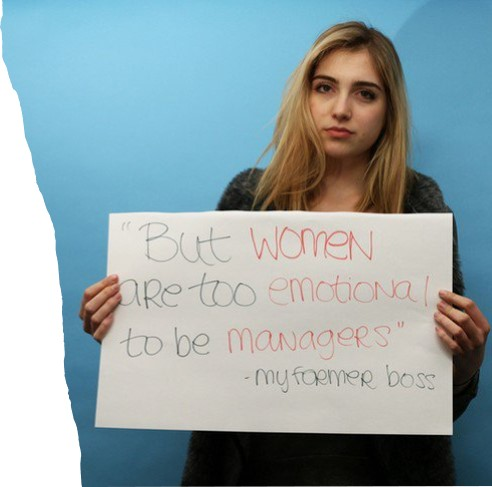

### **TEAM: TeamTokenizers**

**Team members**: [Sarvagya Kumar](https://github.com/Sarvagya2009), [Sunitha Selvan](https://github.com/isunitha98selvan), [Manisha R](https://github.com/Manisha2297), [Padmaja Bhagwat](https://github.com/PadmajaVB)

### **Link to the video and poster** : - https://drive.google.com/drive/folders/1cu2dbYwXPEWpH5XUUAwwm2rW9oktBavr?usp=sharing

## 1 Introduction
Hate speech detectors are being used by social media companies to monitor and flag content which is abusive towards a particular group or section of society. While these detectors do significantly well to flag extremely hostile forms of abuse, they fail miserably at detecting subtler forms of hate speech. There are numerous outlets of subtle hate speech outside of social media, including workplace and places which do not offer the anonymity that is a characteristic of social media. 

Our project is an attempt to improve classification performance on subtle forms of sexism, which is a common problem faced at workplace environments.


## 2 Dataset Description
Primary Dataset was collected from Sexist Workplace Statements: A dataset for sexist statements in the workplace. However due to small training set size, we also scrapped data from The Everyday Sexism Project and used the twitter API to get tweets which were labeled benevolently sexist as per the ambivalent sexism theory (Glick and Fiske, 1996). Additionally, we processed misogynous YouTube comments dataset to extract implicit categories of misogynous statements. 

The preprocessed and merged dataset has 11620 text samples labeled 1 or 0 for sexist and nonsexist sample respectively.


In [ ]:
!pip install tensorflow_addons
!pip install nlpaug
!pip install tqdm
!pip install PrettyTable
!pip install ipdb
!apt-get install libmagic-dev
!pip install python-magic
!pip install ftfy
!pip install tensorflow_addons
!pip install nlpaug
!pip install tqdm

     |████████████████████████████████| 686kB 7.5MB/s 
     |████████████████████████████████| 399kB 8.6MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import nlpaug.augmenter.word as naw

import pickle
from tqdm import tqdm

from nlpaug.util import Action

import tensorflow_addons as tfa
from transformers import  TFDistilBertModel
from transformers import DistilBertTokenizerFast, DistilBertConfig
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Flatten, RepeatVector, Permute, Activation, Dropout, Bidirectional, Multiply, Lambda

import re
import collections
from prettytable import PrettyTable
import urllib.request as urllib2
import os
import ipdb
from bs4 import BeautifulSoup
import time
import sys
import codecs
import csv
import json
from os import listdir
from os.path import isfile, join
import io
import magic
import pickle
import ftfy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3 Data Extraction

### 3.1 Everyday Sexism Project

This is inspired by the data collection work done in paper **[Multi-label Categorization of Accounts of Sexism using a NeuralFramework](https://arxiv.org/abs/1910.04602v4)**

In this paper in order to collect  data, the authours have crawled the Everyday Sexism Project [website](https://everydaysexism.com/), which receives numerous accounts of sexism from survivors themselves as well as observers. 

Here the entries with less than 7 words were removed, post which around 20000 entries were shortlisted for annotation. In this paper, **23 categories** of sexism   were   formulated   taking into  account  gender-related  discourse  and  campaigns as well as possible impact on public policy. We further selected **7 out of 23** categories that are applicable for workplace environment  - ['Attribute stereotyping', 'Role stereotyping', 'Pay gap', 'Hostile work environment', 'Tone policing', 'Moral policing', 'Mansplaining']

Here we're scraping the https://everydaysexism.com/ website based on the placeholder IDs provided by the authors in the tsv file.

In [ ]:
tsv_filepath = '/content/drive/MyDrive/AI-3 Project/data/Everyday Sexism Project/data_placeholders.tsv'
data_write_path = '/content/drive/MyDrive/AI-3 Project/data/Everyday Sexism Project/data.tsv'


def find_post_id(name_box):
    classes = name_box['class']
    for _class in classes:
        if _class[:5] == "post-" and len(_class) > 5:
            return int(_class[5:])
    return -1


def crawl_post(post_page, post_number):
    crawl_page = post_page + str(post_number)

    isCrawledSuccessfully = False
    while not isCrawledSuccessfully:
        try:
            page = urllib2.urlopen(crawl_page).read()
            isCrawledSuccessfully = True
        except urllib2.HTTPError as e:
            if e.code == 404:
                print("\t\t>>> Found 404")
                return None
            else:
                print("\t\t>>> Waitiing for 30 seconds")
                time.sleep(30)
        except Exception:
            print("\t\t>>> Waitiing for 30 seconds")
            time.sleep(30)

    soup = BeautifulSoup(page, 'html.parser')
    name_boxes = soup.find_all('article', attrs={'class': 'post'})
    assert len(name_boxes) == 1
    for i, name_box in enumerate(name_boxes):
        post_id = find_post_id(name_box)
        if post_id == -1:
            print("\t\t>>> ERROR: Error fetching post_id")
            return None
        
        #TODO: VERIFY IF THIS IS CORRECT
        soup = BeautifulSoup(name_box.encode("utf-8"), 'html.parser')
        _name_box = soup.find('div', attrs={'class': 'entry-content'})
        post = _name_box.get_text()
        post = post.replace('\n', '<br/>')
    return post


import re

r_white = re.compile(r'\s+')

xml_csv = open(data_write_path, 'w')
csv_writer = csv.writer(xml_csv, delimiter='\t')
csv_writer.writerow(['post', 'labels'])

post_id_dict = {}

with open(tsv_filepath, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        labels = row[1]
        parts = row[0].split("__")
        post_id__str = parts[0]
        post_offsets__str = [offset.split("_") for offset in parts[1:]]

        if post_id__str in post_id_dict:
            print("accessing " + post_id__str)
            post_text = post_id_dict[post_id__str]
        else:
            print("fetching " + post_id__str)
            post_text = crawl_post("https://everydaysexism.com/everyday-sexism/", post_id__str)
            if post_text == None:
                continue
            post_id_dict[post_id__str] = post_text

        post_text = post_text.replace('<br/>', ' ')
        post_text = re.sub(' +', ' ', post_text)
        post_text = post_text.lstrip()
        post_text__fixed = ftfy.fix_text(post_text)
        text = ""
        for index in range(len(post_offsets__str)):
            text = text + post_text__fixed[int(post_offsets__str[index][0]):int(post_offsets__str[index][1]) + 1]
            if len(post_offsets__str) > 1 and len(post_offsets__str) != index + 1:
                text = text + " "
        text = r_white.sub(' ', text)
        text = text.strip()
        csv_writer.writerow([text, labels])

xml_csv.close()

Here we're filtering the categories relevant to workplace environment.

In [ ]:
df_es = pd.read_csv(data_write_path, sep='\t')

In [ ]:
path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'
data = pd.read_csv(path, sep='\t')

In [ ]:
data.head()

,post,labels
0,"My cousin (female, and 14 years older than me)...","Attribute stereotyping, Body shaming, Denial o..."
1,Big brother came to hang out with us toward th...,Sexual assault (excluding rape)
2,"The next morning, I told my friend. She didn't...","Denial or trivialization of sexist misconduct,..."
3,My ex-boyfriend tried guilt tripping me into s...,"Sexual harassment (excluding assault), Slut sh..."
4,While I was working at McDonald's there was th...,"Hostile work environment (excluding pay gap), ..."


In [ ]:
label_list = ['Attribute stereotyping', 'Role stereotyping', 'Pay gap', 'Hostile work environment', 'Tone policing', 'Moral policing', 'Mansplaining']

In [ ]:
def transform(text, label_list):
  for label in label_list:
    if label in text:
      return 1
  return 0

In [ ]:
data['labels'] = data['labels'].apply(transform,label_list=label_list)
data = data[data['labels']==1]

In [ ]:
data.head()

,post,labels
0,"My cousin (female, and 14 years older than me)...",1
4,While I was working at McDonald's there was th...,1
5,I told multiple supervisors and the head of th...,1
6,I worked as a Project Engineer at a major comp...,1
9,"I wanted to go in the forces and was told ""Wom...",1


In [ ]:
# Renaming the columns for consistency
data.rename(columns = {'post':'Sentences', 'labels':'Label'}, inplace=True)

In [ ]:
data.head()

,Sentences,Label
0,"My cousin (female, and 14 years older than me)...",1
4,While I was working at McDonald's there was th...,1
5,I told multiple supervisors and the head of th...,1
6,I worked as a Project Engineer at a major comp...,1
9,"I wanted to go in the forces and was told ""Wom...",1


In [ ]:
print("Total number of samples = ", len(data))

Total number of samples =  6326


In [ ]:
len_list = [len(x) for x in data.Sentences.values]
print("Length of the longest sentence = ", max(len_list))
print("Length of the shortest sentence = ", min(len_list))

Length of the longest sentence =  879
Length of the shortest sentence =  14


In [ ]:
# Saving the final file
data.to_csv('/content/drive/MyDrive/UnivAI/AI-3 Project/data/Preprocessed data/everyday_sexist_comment.csv')

### 3.2 Get tweets labeled with benevolent sexism using twitter API

According to ambivalent sexism theory (Glick and Fiske, 1996), sexism comes in
two forms: Hostile and Benevolent. While hostile sexism is characterized by an explicitly negative attitude, benevolent sexism is more subtle.

The authors collected data using the public Twitter Search
API. The terms queried were common phrases and
hashtags that are generally used when exhibiting
benevolent sexism. Some of them were: ‘as good
as a man’, ‘like a man’, ‘for a girl’, ‘smart for
a girl’, ‘love of a woman’, ‘#adaywithoutwomen’,
‘#womensday’, ‘#everydaysexism’ and ‘#weareequal’.
These lead to a dataset of tweets that were
sexist in nature, both towards women and men.
E.g.: ‘He is a man who can’t act like a man’ is sexist
towards men. Cross-validation and filtering of the benevolent sexist tweets was done by 3 validators. Fleiss’ kappa score was
calculated to assess the reliability of the agreement
between the validators.

We used twitter API to get the tweets corresponding to the tweet ids provided by the author and fetched the dataset (total 7250 tweets) in 3 runs. Then we combined and removed mentions, hashtag symbol and emojis from the tweets. After filtering for retweets and suspended accounts, we had 400 postive label (benevolent) tweets.

**For more information on this dataset, please visit: https://www.aclweb.org/anthology/W17-2902/**

**Enter twitter developer keys which will be used to comminicate to twitter API using tweepy**

In [ ]:
# Twitter Developer keys here
# USED TO COMMUNICATE TO THE TWITTER API
consumer_key = 'XXXXXXXXX'
consumer_key_secret = 'XXXXXXXXX'
access_token = 'XXXXXXXXX'
access_token_secret = 'XXXXXXXXX'


In [ ]:
#set up the API for fetching
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [ ]:
# This is corpus dataset
#tweet id form (check this tsv for format)
corpusFile = "/content/drive/MyDrive/AI-3 Project/data/NLP_CSS_2017-master/benevolent_sexist.tsv"
df= pd.read_csv(corpusFile, header= None)


**Custom function to fetch tweets and store them as a list (for demonstration we have only fetched 20, but for our task we fetched 7250)**

In [ ]:
# This method creates the training set
def createTrainingSet(corpusFile):
    c=0
    # Get each id as part of the list
    corpus = list(df[0])

    sleepTime = 2
    trainingDataSet = []
    # Do not send more than 1500 ids at once else you will have to wait for 1 hour to cooldown
    for tweet in corpus[0:20]:
        try:
            tweetFetched = api.get_status(tweet) # get the metadeta
            print(c,"Tweet fetched = " + tweetFetched.text)
            c+=1 # counter for seeing which tweet index is being fetched
            time.sleep(sleepTime) # for the API to cool down
            trainingDataSet.append(tweetFetched.text)
        except Exception as e:
            print(c,"Inside the exception - no:2")
            print(e)
            c+=1
            print()
            time.sleep(1)
            continue
                 
    return trainingDataSet
    


In [ ]:
resultFile = createTrainingSet(df)

0 Tweet fetched = RT @GemmaAnneStyles: Happy #womensday to all my sassy women, classy women, nasty women 💋👧🏾💖👩🏼‍🔬👄👵🏼 my fine women, alive women, gonna fight…
1 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

2 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

3 Tweet fetched = RT @girlsreallyrule: The lights are out at the Statue of Liberty...that's ONE MORE woman America CANNOT do without. #adaywithoutwomen #Ligh…
4 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

5 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

6 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

7 Inside the exception - no:2
[{'code': 63, 'message': 'User has been suspended.'}]

8 Inside the exception - no:2
[{'code': 144, 'message': 'No status found with that ID.'}]

9 Inside the exception - no:2
[{'code': 144, 'message': 'No stat

**Convert to dataframe and save**

In [ ]:
res= pd.DataFrame(resultFile)
res.to_csv('first200.csv')
print(res.loc[3][0])

"she parties like a man but loves like a woman"


**Import required libraries and datasets**

In [ ]:
csv1= pd.read_csv('first200.csv', header= None)
csv2= pd.read_csv('1500to4520.csv', header= None)
csv3= pd.read_csv('4520.csv', header= None) 

In [ ]:
csv= pd.concat([csv1, csv2, csv3]) #concatenating the files obtained by running for 3 attempts
csv.drop([0], axis=1, inplace= True) #do .head() before to check if 0th col or row has to be removed
csv.drop([0], axis=0, inplace= True)
csv.head()

,1
1,RT @GemmaAnneStyles: Happy #womensday to all m...
2,RT @girlsreallyrule: The lights are out at the...
3,RT @antonioguterres: We can’t achieve any of o...
4,"""she parties like a man but loves like a woman"""
5,RT @GemmaAnneStyles: Happy #womensday to all m...


**Remove retweets**

In [ ]:
csv.drop_duplicates(inplace=True) #duplicate tweets

In [ ]:
print(len(csv))
csv.head()

401


,1
1,RT @GemmaAnneStyles: Happy #womensday to all m...
2,RT @girlsreallyrule: The lights are out at the...
3,RT @antonioguterres: We can’t achieve any of o...
4,"""she parties like a man but loves like a woman"""
6,RT @xanria_018: Lucky is the man who is the fi...


In [ ]:
csv.reset_index(inplace=True)
csv.drop(['index'], axis=1,inplace= True) 

**Remove @mentions along with emojis and website mentions as they are not important for our task**

In [ ]:
def preprocess(df):
  df[1]= [re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', ln) for ln in df[1]] #remove websites
  df[1]= [re.sub(r'http\S+', '', ln) for ln in df[1]] 
  df[1]= [re.sub('@[^\s]+', '', ln) for ln in df[1]] #remove account mentions
  df[1]= [emoji.get_emoji_regexp().sub(u'', ln) for ln in df[1]] #remove emojis
  df[1]= [ln.split() for ln in df[1]] 
  
  for i,ln in enumerate(df[1]):
    try:
      ln.remove('RT') #remove retweets
    except:
      continue
    df.iloc[i,0]=ln
  [print(ln) for ln in df[1]]
  return df

**Remove any null values**

In [ ]:
csv.dropna(inplace= True) #remove any null values
csv= preprocess(csv)
csv.head()

,1
0,"[Happy, #womensday, to, all, my, sassy, women,..."
1,"[The, lights, are, out, at, the, Statue, of, L..."
2,"[We, can’t, achieve, any, of, our, goals, with..."
3,"[""she, parties, like, a, man, but, loves, like..."
4,"[Lucky, is, the, man, who, is, the, first, lov..."


**Rejoin the split strings as they will be tokenized later as per the model requirements**

In [ ]:
csv=csv[1].str.join(" ")

0      Happy #womensday to all my sassy women, classy...
1      The lights are out at the Statue of Liberty......
2      We can’t achieve any of our goals without the ...
3        "she parties like a man but loves like a woman"
4      Lucky is the man who is the first love of a wo...
                             ...                        
396    Literally can eat a whole pizza to myself .......
397    'THE BIGGEST COWARD OF A MAN IS TO AWAKEN THE ...
398    We want to construct a different world of work...
399    Do not awaken the love of a woman, without the...
400    Nothing better in this world than a man making...
Name: 1, Length: 400, dtype: object

**Save the dataset**

In [ ]:
csv.to_csv("/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/Benevolent_sexism.csv")

After cleaning the dataset, these were merged with the workplace sexism dataset to increase the samples and add variability of different sources to it, so that it generalizes well.

## 4 Combining data from multiple sources

#### 4.1 Reading data from multiple sources to a DataFrame

In [ ]:
benevolent_data_path = '/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/Benevolent_sexism.csv'
sexist_comment_data_path = '/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/everyday_sexist_comment.csv'
reddit_data_path = '/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/reddit (1).csv'
isep_data_path = '/content/drive/MyDrive/AI-3 Project/data/ISEP Sexist Data labeling.xlsx'

In [ ]:
original_data = pd.read_excel(isep_data_path)
benevolent_df = pd.read_csv(benevolent_data_path)
sexist_comment_df = pd.read_csv(sexist_comment_data_path)
reddit_df = pd.read_csv(reddit_data_path)

In [ ]:
X = original_data[['Sentences']]
y = original_data['Label']

#### 4.2 Split the data into train, validation and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=66, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7, stratify=y_train, random_state=66, shuffle=True)

In [ ]:
train_data = X_train.copy()
train_data['Label'] = y_train

test_data = X_test.copy()
test_data['Label'] = y_test

val_data = X_val.copy()
val_data['Label'] = y_val

In [ ]:
val_data = val_data[val_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]
test_data = test_data[test_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]

In [ ]:
new_benevolent_df = benevolent_df[["1"]]
new_benevolent_df['Label'] = 1

In [ ]:
new_benevolent_df.rename(columns={'1': 'Sentences'}, inplace=True)

In [ ]:
sexist_comment_df = pd.read_csv(sexist_comment_data_path)

In [ ]:
new_sexist_comment_df = sexist_comment_df[['Sentences','Label']]

In [ ]:
reddit_df = pd.read_csv(reddit_data_path)

In [ ]:
new_reddit_df = reddit_df[['body','Sexism']]
new_reddit_df.rename(columns={'body':'Sentences','Sexism':'Label'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##### 4.2.1. Combining all the datasets and filter rows with sentence length less than 1000

In [ ]:
sexist_data = pd.concat([new_benevolent_df, new_sexist_comment_df, new_reddit_df, train_data], axis=0)

In [ ]:
sexist_data = sexist_data[sexist_data['Sentences'].apply(lambda x: len(x.split()) < 1000)]

##### 4.2.2 Clean the dataset

In [ ]:
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  return df

In [ ]:
df = clean_data(sexist_data)
test_data = clean_data(test_data)
val_data = clean_data(val_data)

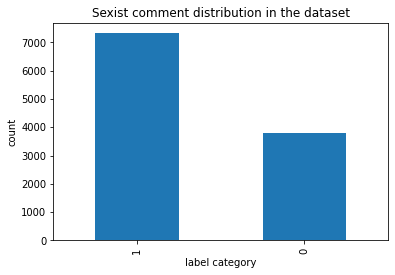

In [ ]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset')
plt.show()

From the above plot, we can see that there is an imbalance in the dataset. Number of negative samples(Non-sexist comments) is almost half of the number of positive samples(Sexist comments) in the dataset.

In [ ]:
df.head()

,Sentences,Label
0,happy womensday to all my sassy women classy w...,1
1,the lights are out at the statue of libertytha...,1
2,we cant achieve any of our goals without the p...,1
3,she parties like a man but loves like a woman,1
4,lucky is the man who is the first love of a wo...,1


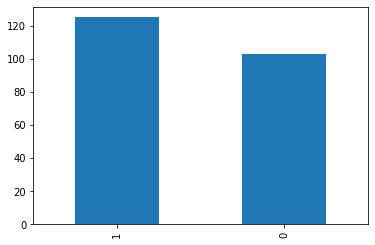

In [ ]:
test_data['Label'].value_counts().plot(kind='bar')

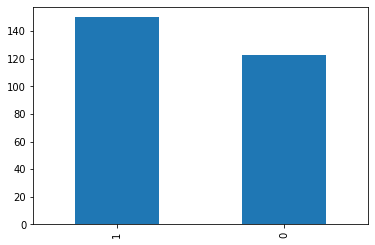

In [ ]:
val_data['Label'].value_counts().plot(kind='bar')

##### 4.2.3 Save the train, validation and test sets into different files

In [ ]:
## Saves the cleaned datasets to respective csv files

# df.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv')
# test_data.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv')
# val_data.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv')

In [ ]:
# Load the saved datasets

df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_dataset.csv')
df_test = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/test_dataset.csv')
df_val = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/val_dataset.csv')

## 5 Data Augementation

As seen above, our dataset is imbalanced. To achieve good performance from the models, we need to balance the data. Data augmentation techniques can be used to generate additional, synthetic data using the existing data.
We have used a python library, NLPAug to achieve this.

NLPAug offers three types of augmentation:
1. Character level augmentation
2. Word level augmentation 
3. Sentence level augmentation
Each of these types can be performed with actions like random deletion, random insertion, shuffling, synonym replacement, etc.

Here, we have used synonym replacement action for Word level augmentation, which randomly picks a word from a sentence and replaces it with a synonym of the word( use word embeddings to find most similar group of words to replace original word).



In [ ]:
def augment_text(df,samples=3000,pr=0.2):
  aug = naw.WordEmbsAug(
  model_type='glove', model_path='/content/drive/MyDrive/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt',
  action="substitute")

  aug.aug_p=pr
  new_text=[]
  
  ##selecting the minority class samples
  df_n=df[df.Label==0].reset_index(drop=True)

  ## data augmentation loop
  for i in tqdm(np.random.randint(0,len(df_n),samples)):
      
          text = df_n.iloc[i]['Sentences']
          augmented_text = aug.augment(text)
          new_text.append(augmented_text)  
  
  new=pd.DataFrame({'Sentences':new_text,'Label':0})
  df=shuffle(df.append(new).reset_index(drop=True))
  return df

In [ ]:
## Uncomment this cell to run Data augmentation on the train dataset

# train = augment_text(df_train)
# train.drop('Unnamed: 0', axis=1, inplace=True)
# train.reset_index(drop=True,inplace=True)

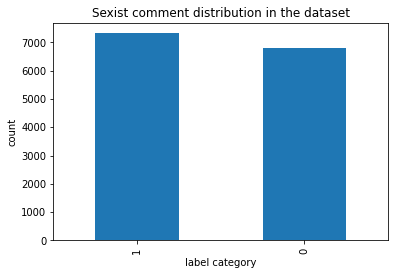

In [ ]:
train['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset after augmentation')
plt.show()

From the above plot, we can see that the class distribution is balanced after data augmentation.

In [ ]:
## Uncomment this cell to save the augmented train data

# train.to_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
# Read the augmented train data

df_train = pd.read_csv('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/augmented_train_dataset.csv')

In [ ]:
X_train = df_train[['Sentences']]
y_train = df_train['Label']

X_val = df_val[['Sentences']]
y_val = df_val['Label']

X_test = df_test[['Sentences']]
y_test = df_test['Label']

In [ ]:
X_train.tail()

,Sentences
14106,having to state your marital status times a d...
14107,my mother commenting on my outfit dont cry to ...
14108,a good man acknowledges a woman than another p...
14109,agree to an extent
14110,joker doesnt even work with a woman besides wa...


In [ ]:
X_train.shape, X_val.shape, X_test.shape

((14111, 1), (273, 1), (228, 1))

## 6 Baseline model with simpleRNN layer

Now that we have a balanced data with upsampled 0 labels, we see the effectiveness of our data in generalizing on postive labels from any source.   

Following the preprocessing of the merged data, we tokenized each sample using the keras tokenizer with a vocab size of 5000. We implemented a SimpleRNN model with an embedding layer as a baseline model and tested its performance on the test dataset. 

We expect the SimpleRNN with its vanishing gradient problem and less context to give a moderate classification performance. 

### 6.1 **Tokenizing text with a fixed vocabulary size**

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

### 6.2 **Create tf.Dataset**

In [ ]:
def create_dataset(x,y):
  ragged_x = tf.ragged.constant(x)
  ragged_y = tf.ragged.constant(y)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_x,ragged_y))
  dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=3)
  dataset = dataset.prefetch(3)
  return dataset

In [ ]:
dataset_train = create_dataset(train_data, df_train["Label"])
dataset_val = create_dataset(val_data, df_val["Label"])
dataset_test = create_dataset(test_data, df_test["Label"])

In [ ]:
print(dataset_train)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int32, tf.int64)>


### 6.3 **Define and train model**

In [ ]:
# baseline model

Inputs=  tf.keras.layers.Input(shape=(None,))
Embedding= tf.keras.layers.Embedding(vocab_size, 300)(Inputs)
RNN_1= (tf.keras.layers.SimpleRNN(32, return_sequences=False))(Embedding)
Dense= tf.keras.layers.Dense(1, activation= 'sigmoid')(RNN_1)
model= tf.keras.Model(inputs= Inputs, outputs= Dense)
model.compile(optimizer=tf.keras.optimizers.Adam(),
                 loss=tf.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 300)         1500000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                10656     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,510,689
Trainable params: 1,510,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history= model.fit(dataset_train, epochs=10, validation_data = dataset_val)

Epoch 1/10
441/441 [==============================] - 51s 112ms/step - loss: 0.6897 - accuracy: 0.5175 - val_loss: 0.6796 - val_accuracy: 0.5751
Epoch 2/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6859 - accuracy: 0.5281 - val_loss: 0.6763 - val_accuracy: 0.5714
Epoch 3/10
441/441 [==============================] - 48s 109ms/step - loss: 0.6853 - accuracy: 0.5306 - val_loss: 0.6829 - val_accuracy: 0.5714
Epoch 4/10
441/441 [==============================] - 48s 107ms/step - loss: 0.6893 - accuracy: 0.5258 - val_loss: 0.6883 - val_accuracy: 0.5421
Epoch 5/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6897 - accuracy: 0.5197 - val_loss: 0.6796 - val_accuracy: 0.5568
Epoch 6/10
441/441 [==============================] - 47s 107ms/step - loss: 0.6875 - accuracy: 0.5302 - val_loss: 0.6790 - val_accuracy: 0.5641
Epoch 7/10
441/441 [==============================] - 48s 108ms/step - loss: 0.6871 - accuracy: 0.5302 - val_loss: 0.6896 - val_ac

**Plotting loss and accuracy**

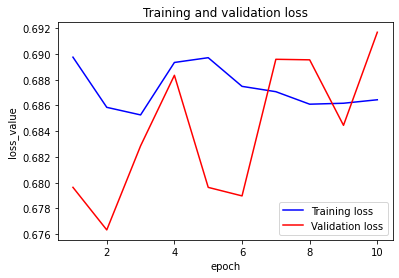

In [ ]:
loss = history.history['loss']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

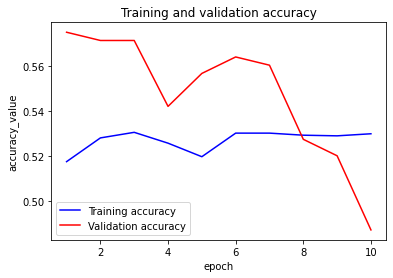

In [ ]:
loss = history.history['accuracy']
epochs = range(1,len(loss)+1)
val_loss = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, loss, 'b', label='Training accuracy')
plt.plot(epochs, val_loss, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Evaluating on the test dataset**

In [ ]:
result = model.evaluate(dataset_test)
dict(zip(model.metrics_names, result))

8/8 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5175


{'accuracy': 0.5175438523292542, 'loss': 0.6889723539352417}

As expected, the model is training ineffectively on data as shown by the plots. This can be attributed to bad generalization to different sources of data in our dataset. Thus this simple model is unable to generalize well. Additionally the test accuracy is extremely less, due to the inefficinecy of the model to capture patterns and key words in our data. 

## 7 ELMo Model

Peter et al. in [Deep contextualized Word Representations](https://arxiv.org/pdf/1802.05365v2.pdf) define 'Embeddings from Language Models', or **ELMo**, as a type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy). Word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus.

A biLM combines both a forward and backward LM. ELMo jointly maximizes the log likelihood of the forward and backward directions. 

We aim to train ELMo embeddings on our train dataset and do transfer learning to use it as layer in the final model which will predict whether a comment is sexist or not.

### 7.1 Preprocessing for ELMo 

We use tensorflow tokeniser and fit it on the train dataset. We use this tokeniser to convert train, test and val data into tokens.

In [ ]:
vocab_size = 5000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token='UNK'
)

tokenizer.fit_on_texts(df_train["Sentences"])
train_data = tokenizer.texts_to_sequences(df_train["Sentences"])
reverse_dict = {j:i for i,j in tokenizer.word_index.items()}

We convert the validation and test datasets to their corresponding tokens based on the vocabulary we built.

In [ ]:
val_data = tokenizer.texts_to_sequences(df_val["Sentences"])
test_data = tokenizer.texts_to_sequences(df_test["Sentences"])

In [ ]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

We read the glove gender neutral embeddings and convert each of the words in each comment to its corresponding embedding. We do cleaning to remove any words which are not present in the glove gender neutral embeddings.

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
          if w in word_to_vec_map:
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map["<s>"] = np.random.randn(300)
word_to_vec_map["</s>"] = np.random.randn(300)

In [ ]:
def get_tokens_embedding_list(data, word_to_vec_map, reverse_dictionary):
  embedding_list = []
  tokens_list = []
  for sent_seq in data:
    tensor_list=[]
    token_temp = []
    for token in sent_seq:
      word = reverse_dictionary[token]
      if word in word_to_vec_map:
        tensor_list.append(word_to_vec_map[word])
        token_temp.append(token)
    embedding_list.append(tensor_list)
    tokens_list.append(token_temp)
  return tokens_list ,embedding_list

In [ ]:
X_train_tokens, X_train_embedding = get_tokens_embedding_list(train_data, word_to_vec_map, reverse_dict)
X_val_tokens, X_val_embedding = get_tokens_embedding_list(val_data, word_to_vec_map, reverse_dict)
X_test_tokens, X_test_embedding = get_tokens_embedding_list(test_data, word_to_vec_map, reverse_dict)

### 7.2 Train ELMo Embeddings

We create the dataset to feed into the ELMo Model. We use a bidirectional LSTM with skip connections as our model. We will define a Toy ELMo Model to extract the embeddings from the layers and use that for tranfer learning.

In [ ]:
def transform_pad(input_tensor, input_target, input_N):
    # Transform the input for the f and b LSTM
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    # Transform the target for the f and b LSTM
    target_f  = input_target[:,1:]
    target_b  = input_target[:,:-1]
    
    # Pad the inputs
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    # Pad the targets
    target_f = target_f.to_tensor(default_value=0, shape=[None, None])
    target_b = target_b.to_tensor(default_value=0, shape=[None, None])
    
    return (input_f, input_b, input_N), (target_f, target_b)

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    ragged_target = tf.ragged.constant(target_in, tf.int32)

    tensor_N = tf.constant(N, tf.int32)
    
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, ragged_target, tensor_N))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    dataset = dataset.map(transform_pad,  num_parallel_calls=4)
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
index = len(X_train_tokens)//2
dataset_train_1 = create_dataset(X_train_embedding[:index], X_train_tokens[:index])
dataset_train_2 = create_dataset(X_train_embedding[index:], X_train_tokens[index:])
dataset_train = dataset_train_1.concatenate(dataset_train_2)
dataset_val  = create_dataset(X_val_embedding, X_val_tokens)

In [ ]:
h_size = 150

tf.keras.backend.clear_session()

inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

masked_f = tf.keras.layers.Masking()(inputs_f)
masked_b = tf.keras.layers.Masking()(inputs_b)

RNN1_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_f)

proyection_Wf = tf.keras.layers.Dense(RNN1_f.units, name='Res_Wf', activation=None)
residual1_f = h1_f + proyection_Wf(masked_f)


RNN2_f = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=False)
h2_f = RNN2_f(residual1_f)

Dense = tf.keras.layers.Dense(vocab_size+1, activation='softmax')

pred_f = Dense(h2_f)

RNN1_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h1_b = RNN1_b(masked_b)

proyection_Wb = tf.keras.layers.Dense(RNN1_b.units, name='Res_Wb', activation=None)
residual1_b = h1_b + proyection_Wb(masked_b)

RNN2_b = tf.keras.layers.LSTM(h_size, return_sequences=True, go_backwards=True)
h2_b = RNN2_b(residual1_b)

pred_b = Dense(h2_b)

model = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (pred_f, pred_b) )
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(dataset_train, epochs=10, validation_data=dataset_val)

Epoch 1/10
222/222 [==============================] - 59s 216ms/step - loss: 3.5638 - dense_loss: 1.7776 - dense_1_loss: 1.7862 - dense_accuracy: 0.8866 - dense_1_accuracy: 0.8871 - val_loss: 5.3292 - val_dense_loss: 2.6702 - val_dense_1_loss: 2.6591 - val_dense_accuracy: 0.5792 - val_dense_1_accuracy: 0.6115
Epoch 2/10
222/222 [==============================] - 46s 208ms/step - loss: 2.0517 - dense_loss: 1.0299 - dense_1_loss: 1.0218 - dense_accuracy: 0.8936 - dense_1_accuracy: 0.8963 - val_loss: 5.2492 - val_dense_loss: 2.6696 - val_dense_1_loss: 2.5796 - val_dense_accuracy: 0.5823 - val_dense_1_accuracy: 0.6093
Epoch 3/10
222/222 [==============================] - 47s 213ms/step - loss: 1.9464 - dense_loss: 0.9780 - dense_1_loss: 0.9684 - dense_accuracy: 0.8993 - dense_1_accuracy: 0.9032 - val_loss: 4.9692 - val_dense_loss: 2.5331 - val_dense_1_loss: 2.4362 - val_dense_accuracy: 0.6089 - val_dense_1_accuracy: 0.6382
Epoch 4/10
222/222 [==============================] - 47s 213ms/ste

In [ ]:
# For the output of Toy_Elmo, we have to extract the embeddings for each word.
# We have to remove the embeddings for <s> and </s>.
# And we have to invert the backwards LSTM embeddings.

# First we remove the </s> token from the backwards hidden states
mask1 = tf.sequence_mask(inputs_N-2, tf.shape(h1_b)[1]) 
mask2 = tf.math.logical_not(tf.sequence_mask(inputs_N -1,tf.shape(h1_b)[1])) 
mask = tf.math.logical_or(mask1, mask2)

# We invert the backwards embeddings
h1_b = h1_b[:,::-1,:]
h2_b = h2_b[:,::-1,:]
h1_b_m = tf.reshape(h1_b[mask],(tf.shape(h1_b)[0], tf.shape(h1_b)[1]-1, h_size) )
h2_b_m = tf.reshape(h2_b[mask],(tf.shape(h2_b)[0], tf.shape(h2_b)[1]-1, h_size) )


# Concatenate the embeddings
# Note that we skip the first element in the forward embeddings
# since the first token contains the hidden state of the <s>
h1 = tf.keras.layers.Concatenate(axis=2)([h1_f[:,1:,:], h1_b_m])
h2 = tf.keras.layers.Concatenate(axis=2)([h2_f[:,1:,:], h2_b_m])

# We extract the w2v embeddings from the forward input
# removing the first element corresponding to the <s> token.
w2v_emb = masked_f[:,1:,:]

Toy_ELMo = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs = (w2v_emb, h1, h2) )

In [ ]:
for i in dataset_train:
    result = Toy_ELMo(i[0])
    break

In [ ]:
result[0].shape, result[1].shape, result[2].shape

(TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]),
 TensorShape([64, 866, 300]))

### 7.3 Transfer Learning:

We use the train and validation dataset and convert it into a dataset object which can be used further for training the model. We define a Sauce layer to learn the embeddings for elmo from our dataset. The model will predict whether the comment is sexist or not.

In [ ]:
def transform_pad(input_tensor, input_N, class_target):
    input_f  = input_tensor[:,:-1,:]
    input_b  = input_tensor[:,1:,:]
    
    input_f  = input_f.to_tensor(default_value=0, shape=[None, None, 300])
    input_b  = input_b.to_tensor(default_value=0, shape=[None, None, 300])
    
    return (input_f, input_b, input_N), class_target

def create_dataset(data_in, target_in):
   
    N = [len(n) for n in data_in]
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    class_target = tf.ragged.constant(target_in, tf.int32)
    tensor_N = tf.constant(N, tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, tensor_N, class_target))
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(128)
    dataset = dataset.map(transform_pad, num_parallel_calls=4)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
sexism_train = create_dataset(X_train_embedding, df_train["Label"])
sexism_val = create_dataset(X_val_embedding, df_val["Label"])
sexism_test = create_dataset(X_test_embedding, df_test["Label"])

In [ ]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, input_shape):
        self.scale = tf.Variable(tf.nn.softmax([0.4,0.3,0.3]), trainable=True)
    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)
        return tf.tensordot(scale_norm, inputs, axes=1)

In [ ]:
tf.keras.backend.clear_session()
Toy_ELMo.trainable=False
# Define the inputs
inputs_f = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_b = tf.keras.Input(shape=(None,300), dtype=tf.float32)
inputs_N = tf.keras.Input(shape=(), dtype=tf.int32)

# Get the embeddings
e0,e1,e2 = Toy_ELMo((inputs_f, inputs_b, inputs_N))

# Make the sauce
Sauce_layer = ScaleLayer(3)
sauce = Sauce_layer(tf.stack([e0,e1,e2]))

# Define the masking
masked_sauce = tf.keras.layers.Masking()(sauce)

# Define the forward LSTM
RNN1_f = tf.keras.layers.LSTM(300, return_sequences=True, go_backwards=False)
h1_f = RNN1_f(masked_sauce)

RNN2_f = tf.keras.layers.LSTM(300, return_sequences=False, go_backwards=False)
h2_f = RNN2_f(h1_f)

pred = tf.keras.layers.Dense(2, activation='softmax')(h2_f)

model3 = tf.keras.Model(inputs=(inputs_f, inputs_b, inputs_N), outputs=pred)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

In [ ]:
history3 = model3.fit(sexism_train, epochs=20, validation_data=sexism_val)

Epoch 1/20
111/111 [==============================] - 45s 293ms/step - loss: 0.6566 - accuracy: 0.6208 - val_loss: 0.7591 - val_accuracy: 0.4469
Epoch 2/20
111/111 [==============================] - 29s 262ms/step - loss: 0.6121 - accuracy: 0.6756 - val_loss: 0.7678 - val_accuracy: 0.4762
Epoch 3/20
111/111 [==============================] - 30s 271ms/step - loss: 0.6005 - accuracy: 0.6817 - val_loss: 0.8506 - val_accuracy: 0.4579
Epoch 4/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5929 - accuracy: 0.6907 - val_loss: 0.8265 - val_accuracy: 0.4762
Epoch 5/20
111/111 [==============================] - 30s 268ms/step - loss: 0.5840 - accuracy: 0.6904 - val_loss: 0.7508 - val_accuracy: 0.4835
Epoch 6/20
111/111 [==============================] - 31s 273ms/step - loss: 0.5755 - accuracy: 0.6981 - val_loss: 0.7756 - val_accuracy: 0.4945
Epoch 7/20
111/111 [==============================] - 30s 271ms/step - loss: 0.5649 - accuracy: 0.7046 - val_loss: 0.8271 - val_ac

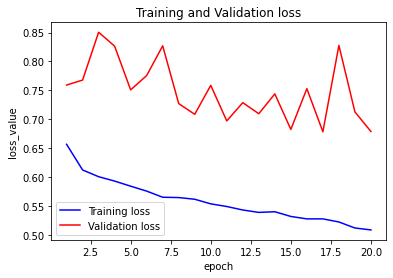

In [ ]:
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1,len(train_loss)+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

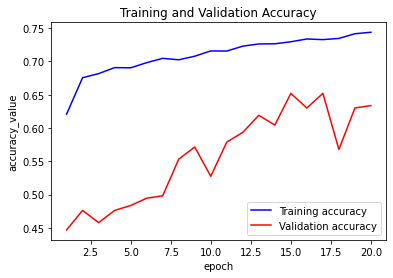

In [ ]:
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

epochs = range(1,len(train_acc)+1)

plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

In [ ]:
result = model3.evaluate(sexism_test)
dict(zip(model3.metrics_names, result))

2/2 [==============================] - 0s 20ms/step - loss: 0.7032 - accuracy: 0.6360


{'accuracy': 0.6359649300575256, 'loss': 0.7032281756401062}

## 8 Bidirectional LSTM using Gender neutral GLoVe embeddings

### 8.1 Loading the Gender neutral GLoVe embedding

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map['and'].shape

(300,)

In [ ]:
vocab = list(words_to_index.keys())
len(vocab)

142527

### 8.2 Getting word embeddings for the input data - X_train and X_test

In [ ]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        #print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [ ]:
## Note: This takes a lot of time to create embeddings list as the dataset is huge. Please load the embedding list from the cell below.

# X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)
# with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'wb') as f:
#   pickle.dump(X_train_embedding, f)

In [ ]:
with open('/content/drive/MyDrive/AI-3 Project/data/Preprocessed data/train_embedding_list_1', 'rb') as f:
  X_train_embedding = pickle.load(f)

In [ ]:
X_val_embedding = get_tokens_embedding_list(X_val.values, vocab, word_to_vec_map)

In [ ]:
X_test_embedding = get_tokens_embedding_list(X_test.values, vocab, word_to_vec_map)

In [ ]:
def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    N = [len(data_in[i]) for i, _ in enumerate(data_in)]
    embedding_size = 300
    tensor_N = tf.constant(N, tf.int32)
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    print(ragged_input.shape)

    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, target_in))
    del ragged_input

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(64)
    
    # Transform_pad function is defined above; you can change the num_parallel_calls
    dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, embedding_size]), y), num_parallel_calls=3)   
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_dataset = create_dataset(X_train_embedding, y_train)
val_dataset = create_dataset(X_val_embedding, y_val)

(14111, None, None)
(273, None, None)


In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, None, 300), (None,)), types: (tf.float32, tf.int64)>

### 8.3 Bidirectional LSTM Model


The model employs a Bidirectional LSTM deep learning architecture. After extracting the embeddings for the input sentences from Gender neutral GLoVe, inputs are propagated through two bidirectional LSTM layers.

This model should be able to read the sentences both forwards and backwards to better learn their nuanced meanings.

In [ ]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='sigmoid')(dropout_2)

lstm_model = Model(inputs=input_layer, outputs=dense)

In [ ]:
lstm_model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional_26 (Bidirectio (None, None, 256)         439296    
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 256)               394240    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
____________________________________________________

In [ ]:
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='bce', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = lstm_model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1, callbacks=[callback])

Epoch 1/10
221/221 [==============================] - 29s 111ms/step - loss: 0.5922 - accuracy: 0.6899 - val_loss: 0.6578 - val_accuracy: 0.6117
Epoch 2/10
221/221 [==============================] - 23s 105ms/step - loss: 0.5475 - accuracy: 0.7253 - val_loss: 0.6156 - val_accuracy: 0.6703
Epoch 3/10
221/221 [==============================] - 23s 103ms/step - loss: 0.5179 - accuracy: 0.7393 - val_loss: 0.5949 - val_accuracy: 0.6960
Epoch 4/10
221/221 [==============================] - 23s 104ms/step - loss: 0.4903 - accuracy: 0.7558 - val_loss: 0.5473 - val_accuracy: 0.7582
Epoch 5/10
221/221 [==============================] - 23s 103ms/step - loss: 0.4562 - accuracy: 0.7790 - val_loss: 0.5484 - val_accuracy: 0.7436
Epoch 6/10
221/221 [==============================] - 23s 104ms/step - loss: 0.4274 - accuracy: 0.7989 - val_loss: 0.5634 - val_accuracy: 0.7363


Train accuracy is: 79.89%
Validation accuracy is: 73.63%

In [ ]:
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i, metric in enumerate(['loss', 'accuracy']): 
        ax[i].plot(history.history[metric], label='Train')
        ax[i].plot(history.history['val_'+metric], label='Validation')
        if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Training', y=1.05)
    plt.legend()
    plt.tight_layout()

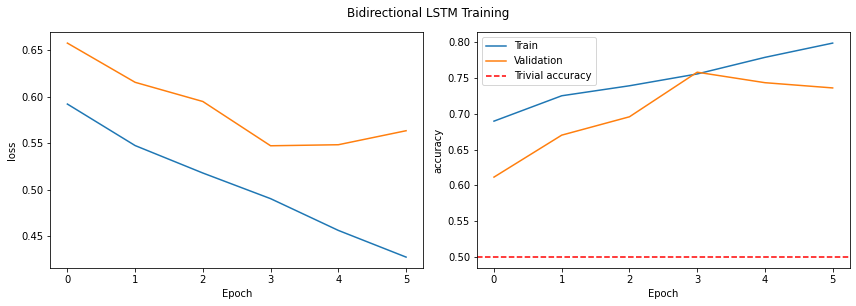

In [ ]:
plot_history(history, 'Bidirectional LSTM')

We can see that the validation loss is increasing and accuracy decreasing after 3 epochs. So, the training stopped after 5 epochs(EarlyStopping with patience 2) to avoid overfitting.

In [ ]:
## Uncomment this cell to save the trained LSTM model

# lstm_model.save('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AI-3 Project/Models/lstm_model_1/assets


In [ ]:
lstm_model = load_model('/content/drive/MyDrive/AI-3 Project/Models/lstm_model_1')

In [ ]:
# Converting the test set into test dataset
ragged_input_test  = tf.ragged.constant(X_test_embedding, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_input_test, y_test.values))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1)
test_dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, 300]),y), num_parallel_calls=3)


In [ ]:
loss, acc = lstm_model.evaluate(test_dataset)

228/228 [==============================] - 2s 5ms/step - loss: 0.5570 - accuracy: 0.7412


In [ ]:
print("Test accuracy for Bi-LSTM is: ", acc)

Test accuracy for Bi-LSTM is:  74.12


Bidirectional LSTM model is able to perform better than the baseline model with the test accuracy of 74.12%. As mentioned above, this model is able to capture the meaning of the sentences better.

## 9 DistillBert

### 9.1 DistillBert on Unbalanced data

**Using df_train, df_val, df_test for finetuning DistillBert model**

In [ ]:
X_train=list(df_train.Sentences)
X_val=list(df_val.Sentences)
X_test=list(df_test.Sentences)


y_train=list(df_train.Label)
y_val=list(df_val.Label)
y_test=list(df_test.Label)

#### 9.1.1 **Tokenizing the Sentences and returning the input ids and attention masks which is the combined input to BERT**

In [ ]:
def batch_encode(tokenizer, texts, batch_size=128, max_length=1000):
    """""""""
    A function that encodes a batch of texts and returns the texts'
    corresponding encodings and attention masks that are ready to be fed 
    into a pre-trained transformer model.
    
    Input:
        - tokenizer:   Tokenizer object from the PreTrainedTokenizer Class
        - texts:       List of strings where each string represents a text
        - batch_size:  Integer controlling number of texts in a batch
        - max_length:  Integer controlling max number of words to tokenize in a given text
    Output:
        - input_ids:       sequence of texts encoded as a tf.Tensor object
        - attention_mask:  the texts' attention mask encoded as a tf.Tensor object
    """""""""
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="tf", padding = 'max_length', max_length= max_length, truncation= True)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
      
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [ ]:
# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train)

# Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_val)

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test)

**Taking the hidden state of DistillBERT's last embedding layer and getting only the sentence embeddings (specifically the CLS token of the last layer which has information about sentence)**




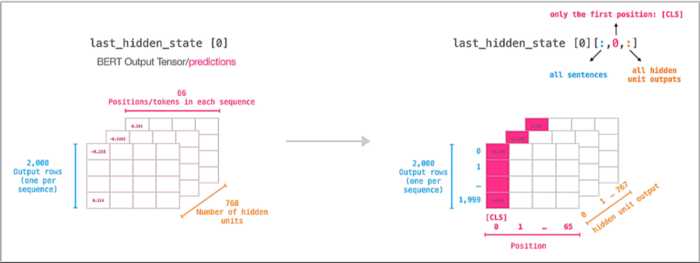




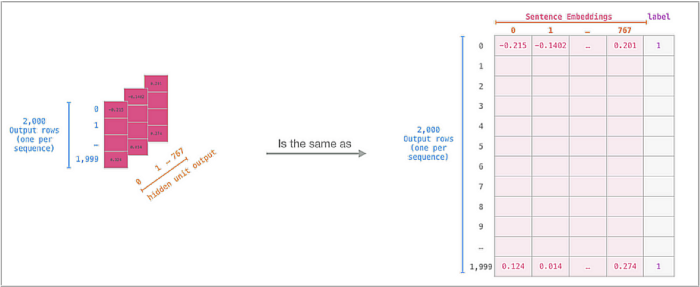

Source of images:
http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

In [ ]:

def build_model(transformer, max_length=1000):
    """
    Template for building a model off of the BERT or DistilBERT architecture
    for a binary classification task.
    
    Input:
      - transformer:  a base Hugging Face transformer model object (BERT or DistilBERT)
                      with no added classification head attached.
      - max_length:   integer controlling the maximum number of encoded tokens 
                      in a given sequence.
    
    Output:
      - model:        a compiled tf.keras.Model with added classification layers 
                      on top of the base pre-trained model architecture.
    """
    
    # Define weight initializer with a random seed to ensure reproducibility
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42) 
    
    # Define input layers
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    # DistilBERT outputs a tuple where the first element at index 0
    # represents the hidden-state at the output of the model's last layer.
    # It is a tf.Tensor of shape (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    #last_hidden_state = transformer([input_ids_layer])[0]
    # We only care about DistilBERT's output for the [CLS] token, which is located
    # at index 0.  Splicing out the [CLS] tokens gives us 2D data.
    cls_token = last_hidden_state[:, 0, :]
    D1 = tf.keras.layers.Dropout(0.2, seed=42)(cls_token)
    
    X = tf.keras.layers.Dense(256,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D1)
    
    D2 = tf.keras.layers.Dropout(0.2, seed=42)(X)
    
    X = tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=weight_initializer,
                              bias_initializer='zeros'
                              )(D2)

                            
    D3 = tf.keras.layers.Dropout(0.2, seed=42)(X)

    
    # Define a single node that makes up the output layer (for binary classification)
    output = tf.keras.layers.Dense(1, 
                                   activation='sigmoid',
                                   kernel_initializer=weight_initializer,  # CONSIDER USING CONSTRAINT
                                   bias_initializer='zeros'
                                   )(D3)
    
    # Define the model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile the model
    model.compile(tf.keras.optimizers.Adam(learning_rate= 5e-5), loss='bce', metrics=['accuracy'])#)
    return model

In [ ]:
config = DistilBertConfig(dropout=0.2, 
                          attention_dropout=0.1, 
                          output_hidden_states=False, output_attentions=False,return_dict =True)

distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config)

for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


**The overall model architecture is TFDistillBert with a custom classification head of Dense(256), Dense(32), Dense(1 with sigmoid activation) and dropout of 0.2 in between.**

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 1000)]       0                                            
__________________________________________________________________________________________________
tf_distil_bert_model (TFDistilB TFBaseModelOutput(la 66362880    input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           tf_distil_bert_model[0][0]   

#### 9.1.2 **Model training for Frozen DistillBert with classification head**

In [ ]:
# Train the model
train_history1 = model.fit(
    x = [X_train_ids, X_train_attention],
    y = np.array(y_train),
    epochs = 8,
    batch_size = 64,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)

Epoch 1/8
174/174 [==============================] - 335s 2s/step - loss: 0.6098 - accuracy: 0.6659 - val_loss: 0.6623 - val_accuracy: 0.5714
Epoch 2/8
174/174 [==============================] - 329s 2s/step - loss: 0.4976 - accuracy: 0.7556 - val_loss: 0.5962 - val_accuracy: 0.7070
Epoch 3/8
174/174 [==============================] - 329s 2s/step - loss: 0.4171 - accuracy: 0.8100 - val_loss: 0.5735 - val_accuracy: 0.7473
Epoch 4/8
174/174 [==============================] - 329s 2s/step - loss: 0.3849 - accuracy: 0.8305 - val_loss: 0.5708 - val_accuracy: 0.7289
Epoch 5/8
174/174 [==============================] - 329s 2s/step - loss: 0.3625 - accuracy: 0.8402 - val_loss: 0.5661 - val_accuracy: 0.7509
Epoch 6/8
174/174 [==============================] - 329s 2s/step - loss: 0.3553 - accuracy: 0.8444 - val_loss: 0.5578 - val_accuracy: 0.7473
Epoch 7/8
174/174 [==============================] - 329s 2s/step - loss: 0.3410 - accuracy: 0.8535 - val_loss: 0.5535 - val_accuracy: 0.7509
Epoch 

**Plotting the model performance**

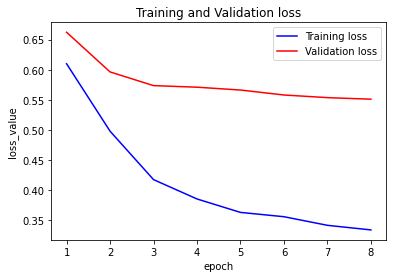

In [ ]:
train_loss = train_history1.history['loss']
val_loss = train_history1.history['val_loss']

epochs = range(1,len(train_loss)+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend()
plt.show()

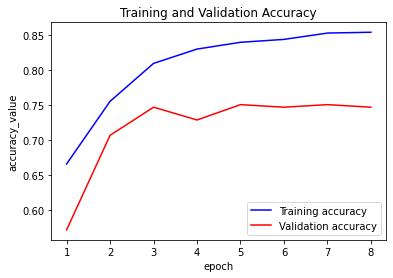

In [ ]:
train_acc = train_history1.history['accuracy']
val_acc = train_history1.history['val_accuracy']

epochs = range(1,len(train_acc)+1)

plt.figure()
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label ='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy_value')
plt.legend()
plt.show()

**Trying the model on test data**

In [ ]:
loss, accuracy = model.evaluate([X_test_ids, X_test_attention], np.array(y_test))
print("test loss: ", loss)
print("test accuracy: ", accuracy)

8/8 [==============================] - 5s 667ms/step - loss: 0.5885 - accuracy: 0.6798
test loss:  0.5884889960289001
test accuracy:  0.6798245906829834


### 9.2 DistillBert Balanced data

#### 9.2.1 **Tokenizing augmented dataset with class balance**

In [ ]:
X_train_aug= list(df_augmented_train.Sentences)
y_train_aug= list(df_augmented_train.Label)

In [ ]:
# Encode X_train_aug
X_train_aug_ids, X_train_aug_attention = batch_encode(tokenizer, X_train_aug)

#### 9.2.2 **Training DistillBert on augmented dataset at the same time keeping validation data same as before**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Train the model
train_history2 = model.fit(
    x = [X_train_aug_ids, X_train_aug_attention],
    y = np.array(y_train_aug),
    epochs = 7,
    batch_size = 64,
    validation_data = ([X_valid_ids, X_valid_attention], np.array(y_val)), verbose=1
)

Epoch 1/7
221/221 [==============================] - 416s 2s/step - loss: 0.5096 - accuracy: 0.7458 - val_loss: 0.5667 - val_accuracy: 0.7033
Epoch 2/7
221/221 [==============================] - 415s 2s/step - loss: 0.5022 - accuracy: 0.7529 - val_loss: 0.5694 - val_accuracy: 0.7143
Epoch 3/7
221/221 [==============================] - 416s 2s/step - loss: 0.4854 - accuracy: 0.7642 - val_loss: 0.5840 - val_accuracy: 0.7070
Epoch 4/7
221/221 [==============================] - 416s 2s/step - loss: 0.4797 - accuracy: 0.7678 - val_loss: 0.5922 - val_accuracy: 0.7033
Epoch 5/7
221/221 [==============================] - 416s 2s/step - loss: 0.4765 - accuracy: 0.7749 - val_loss: 0.5933 - val_accuracy: 0.7106
Epoch 6/7
221/221 [==============================] - 416s 2s/step - loss: 0.4729 - accuracy: 0.7688 - val_loss: 0.5923 - val_accuracy: 0.6923
Epoch 7/7
221/221 [==============================] - 416s 2s/step - loss: 0.4674 - accuracy: 0.7747 - val_loss: 0.5973 - val_accuracy: 0.6923


**Trying the model on test data**

In [ ]:
loss, accuracy = model.evaluate([X_test_ids, X_test_attention], np.array(y_test))
print("test loss: ", loss)
print("test accuracy: ", accuracy)

8/8 [==============================] - 5s 667ms/step - loss: 0.6270 - accuracy: 0.6842
test loss:  0.6269809603691101
test accuracy:  0.6842105388641357


**Plotting the training history for both datasets to measure performance**

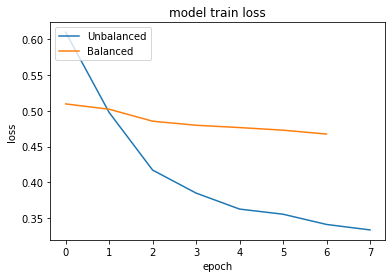

In [ ]:
plt.plot(train_history1.history['loss'])
plt.plot(train_history2.history['loss'])
plt.title('model train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

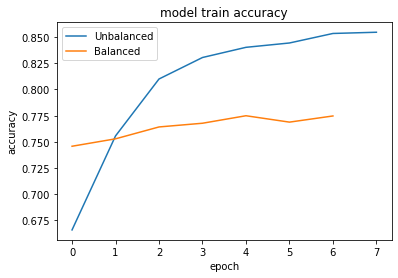

In [ ]:
plt.plot(train_history1.history['accuracy'])
plt.plot(train_history2.history['accuracy'])
plt.title('model train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

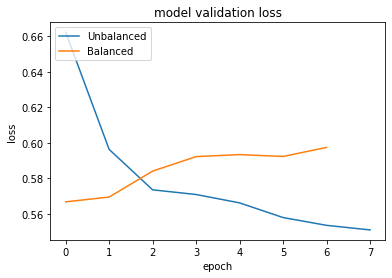

In [ ]:
plt.plot(train_history1.history['val_loss'])
plt.plot(train_history2.history['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

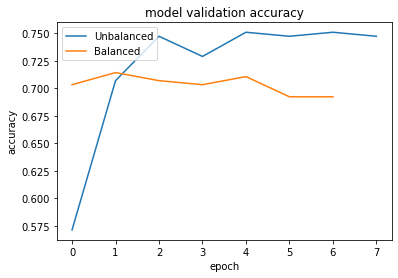

In [ ]:
plt.plot(train_history1.history['val_accuracy'])
plt.plot(train_history2.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Unbalanced', 'Balanced'], loc='upper left')
plt.show()

Using DistillBert on the augmented dataset resulted in decrease of training and validation accuracy with a higher loss. This happens because the upsampling a large corpus generally leads to a very mixed dataset which leads to difficulty in learning patterns in the data.
In addition, it can be observed that attention does not seem to have much impact on model performance. Infact the Bidirectional LSTM without attention seems to perform better. In this case is attention what we really need?

## 10 Results


In [6]:
model_comparison = PrettyTable()
model_comparison.field_names = ["Method", "Validation Accuracy", "Test Accuracy"]
model_comparison.add_row(["Baseline RNN Model", 48.72, 51.75])
model_comparison.add_row(["Elmo Model", 63.37, 63.59])
model_comparison.add_row(["Bidirectional LSTM", 73.63, 74.12])
model_comparison.add_row(["DistilBert", 74.73, 67.98])

print(model_comparison)

+--------------------+---------------------+---------------+
|       Method       | Validation Accuracy | Test Accuracy |
+--------------------+---------------------+---------------+
| Baseline RNN Model |        48.72        |     51.75     |
|     Elmo Model     |        63.37        |     63.59     |
| Bidirectional LSTM |        73.63        |     74.12     |
|     DistilBert     |        74.73        |     67.98     |
+--------------------+---------------------+---------------+


## 11 Conclusion

1. We extracted data from multiple sources, cleaned the data.
2. We augmented the dataset to balance the positive and negative samples.
3. We tested with several models including DistillBert. We could see that Bidirectional LSTM with Gender Neutral GLoVe embeddings performed the best in detecting sexism. 
4. Models with attention could not perform better because of the dataset we are using. Most of the data we have are from Twitter and reddit which tend to be more hostile comments whereas the test set mostly has benevolent comments.So, focusing on hostile words did not improve the performance of the models.
5. Using DistillBert on the augmented dataset resulted in decrease of training and validation accuracy with a higher loss. This happens because the upsampling a large corpus generally leads to a very mixed dataset which leads to difficulty in learning patterns in the data.


## 12 Future Work

We have currently collected our data from multiple sources and done data augmentation. The training and validation set consist of examples from all sources whereas the test set consists of examples only from Sexist Workplace Statements [dataset](https://https://www.kaggle.com/dgrosz/sexist-workplace-statements/code). The goal was to train on different sources and see how it would perform for this targetted dataset. While the current dataset has produced good results with various models, the dataset can grow to capture more phrase structures and keywords. In many scenarios, the words are purposely misspelt or various slangs are used which need to be captured. The same word may be written in different spellings, with * etc. All of these should be mapped to the same word. 

Sexist comments in the Indian setting present a unique challenge with usage of words from various regional languages written in English. These often go undetected. Models would have to be built to specifically deal with such cases of code-switching.

## 13 Experiments

We experiment with different model architectures based on various papers we read related to Hate Speech Detection. 

1. LSTM with no-pretrained embedding: Pitsilis et al. in ["Detecting offensive language in tweets using deep learning".](https://arxiv.org/abs/1801.04433) talk about how the words used in sexist comments are not always captured by Glove or Word2Vec embeddings (as these are trained on Wikipedia or Google news data. They argue that for better performance, we should use a Embedding layer which will be learnt during training. The model consists of two LSTMs stacked together. We implemented the model for our dataset however, we achieved sub-par performance compared to using Glove embeddings. The main reason for this could be due to the difference in the datasets. Our dataset consists of Reddit, Twitter comments in proper English (making it more likely that these words will be present in the Glove Embedding file) whereas their dataset consists of Hinglish, Bangla words etc as well.

2. LSTM with Attention Layer: We experiment with a bi-directional LSTM model with an attention layer. However, the performance is poorer than of the bi-directional model without attention. A plausible reasoning could be that this occurs as most of our sentences are short in length as they are taken from Twitter. 


Link to notebook with the experiments: [Experimentation.ipynb](https://github.com/PadmajaVB/Sexist-Statement-Detection/blob/main/Experimentation.ipynb)
